In [1]:
# Import necessary libraries
from fastai.basics import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.all import *

from fastai.metrics import *
from fastai.callback.wandb import *
from pathlib import Path

from tqdm import tqdm

import wandb
wandb.login()

wandb: Currently logged in as: basedrhys (use `wandb login --relogin` to force relogin)


True

In [2]:
path = Path("/scratch/rc4499/NLM-kaggle")
image_path = path/"CXR_png"
mask_path = path/"masks"

In [3]:
img_fnames = get_image_files(image_path)
mask_fnames = get_image_files(mask_path)

len(img_fnames), len(mask_fnames)

(704, 704)

In [4]:
def get_msk(o):
    m_path = mask_path/o.name
    msk = np.array(PILMask.create(m_path))
    msk[msk == 255] = 1
    assert msk.max() == 1
    return PILMask.create(msk)

codes = ["bg", "fg"]

In [5]:
lungs = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                  get_items=get_image_files,
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_y=get_msk,
                  batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
                   item_tfms=Resize(448, method="pad", pad_mode="zeros"))

/ext3/miniconda3/envs/ml4h/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/ext3/miniconda3/envs/ml4h/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/p

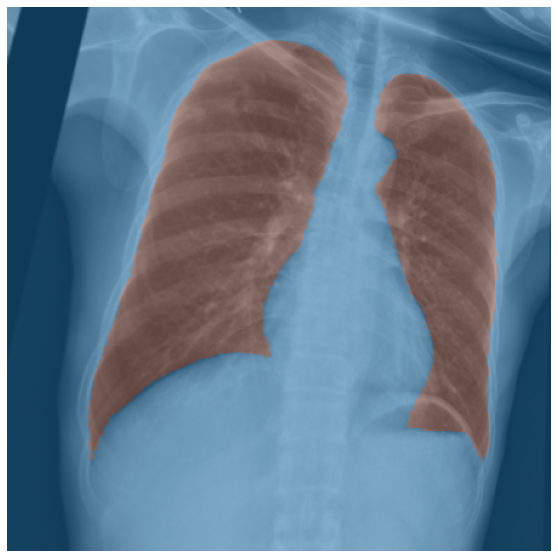

In [6]:
dls = lungs.dataloaders(image_path, bs=1)
dls.vocab = codes
dls.show_batch(figsize=(16,10))

In [7]:
wandb.init(project="ml4h",
        name="lr_find_seg",
        job_type="lr_find")

In [8]:
learn = unet_learner(dls, resnet50, metrics=Dice, 
                     self_attention=True, 
                     act_cls=Mish, opt_func=ranger, 
                     cbs=[WandbCallback(), SaveModelCallback()])
#                         EarlyStoppingCallback(monitor='dice', min_delta=0.001, patience=2)])

SuggestedLRs(valley=1.2022644114040304e-05)

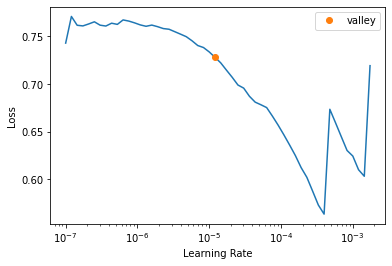

In [9]:
# learn.summary()
learn.lr_find()

In [7]:
wandb.init(project="ml4h",
        name="train_seg_padzeros",
        job_type="train")

In [9]:
learn.fit_one_cycle(8, 1e-5)

epoch,train_loss,valid_loss,dice,time
0,0.082636,0.075244,0.938856,04:35
1,0.075601,0.059617,0.952638,04:33
2,0.058696,0.048359,0.961141,04:35
3,0.054129,0.044205,0.963792,04:35
4,0.052112,0.043592,0.963671,04:35
5,0.042250,0.047008,0.961402,04:35
6,0.041959,0.043523,0.964518,04:36
7,0.045470,0.043784,0.964583,04:36


Better model found at epoch 0 with valid_loss value: 0.07524429261684418.
Better model found at epoch 1 with valid_loss value: 0.059617068618535995.
Better model found at epoch 2 with valid_loss value: 0.04835866391658783.
Better model found at epoch 3 with valid_loss value: 0.044205259531736374.
Better model found at epoch 4 with valid_loss value: 0.04359173774719238.
Better model found at epoch 6 with valid_loss value: 0.04352276399731636.


# Save Model

In [9]:
filename = 'combined-2-v3-padzero'

In [11]:
learn.save(filename)
learn.load(filename)

wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.


In [12]:
model_artifact = wandb.Artifact('seg_model', type='seg_model')
model_artifact.add_file(f"models/{filename}.pth")
wandb.run.log_artifact(model_artifact)

In [13]:
wandb.finish()

beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dice,▁▅▇██▇██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_2,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁


# Inspect Model

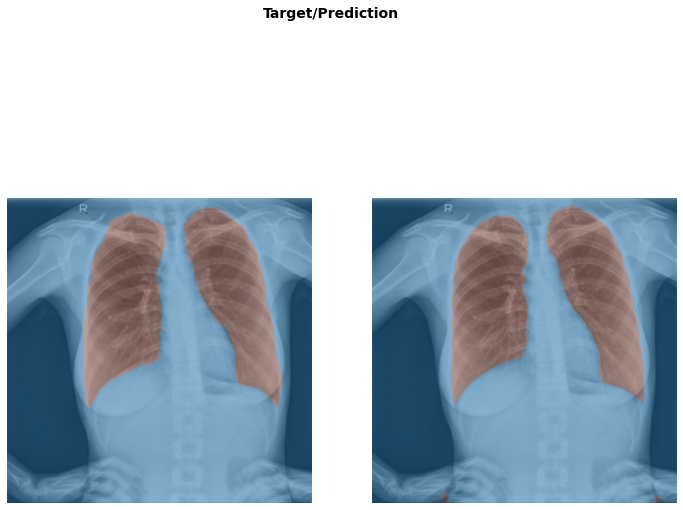

In [14]:
learn.show_results(max_n=4, figsize=(12,10))

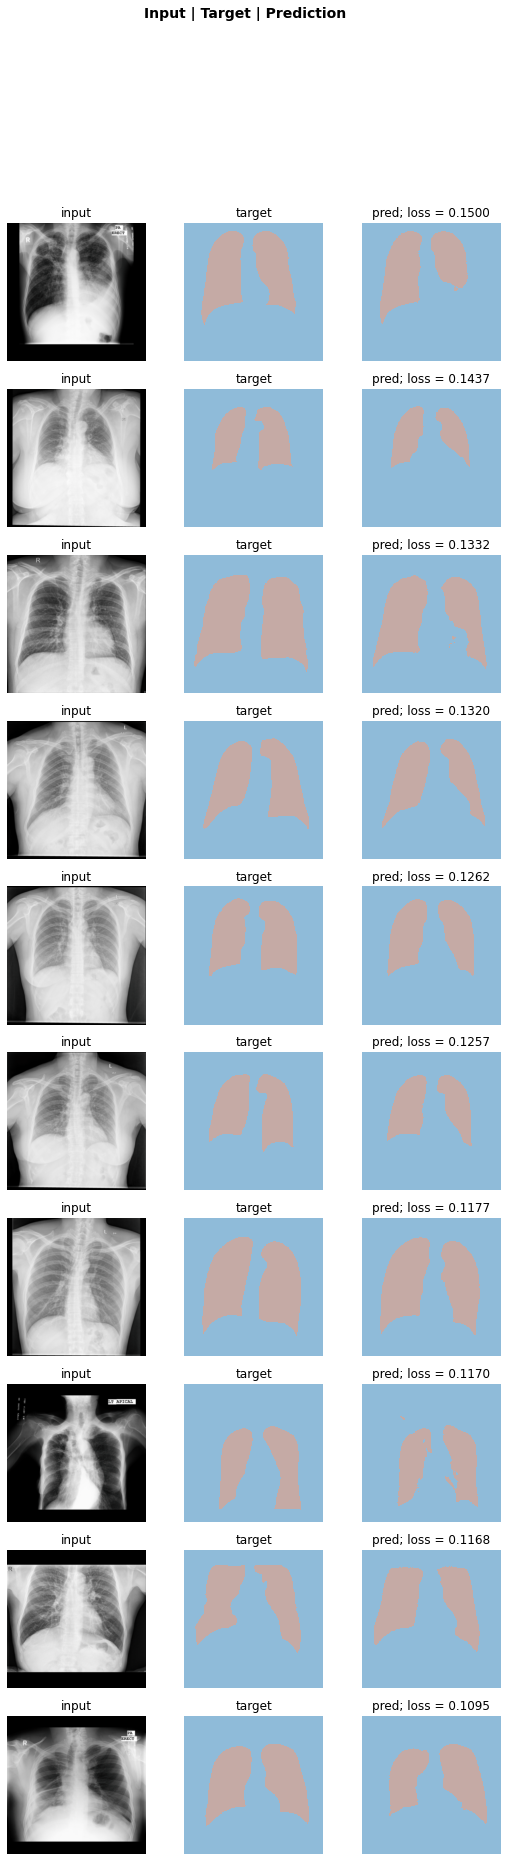

In [14]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=10)

# Run Inference

In [7]:
lungs = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                  get_items=get_image_files,
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_y=get_msk,
                  batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                   item_tfms=Resize(448, method="pad", pad_mode="zeros"))

In [8]:
dls = lungs.dataloaders(image_path, bs=1)
dls.vocab = codes

In [10]:
learn = unet_learner(dls, resnet50, metrics=Dice, 
                     self_attention=True, 
                     act_cls=Mish, opt_func=ranger)
learn.load(filename)

In [11]:
root_path = Path("/scratch/rc4499/chexpert_pn")
img_path = root_path/"imgs"

test_imgs = get_image_files(img_path)
test_imgs.sort()
test_imgs

(#14228) [Path('/scratch/rc4499/chexpert_pn/imgs/NORMAL/patient00004_study1_view1_frontal.jpg'),Path('/scratch/rc4499/chexpert_pn/imgs/NORMAL/patient00006_study1_view1_frontal.jpg'),Path('/scratch/rc4499/chexpert_pn/imgs/NORMAL/patient00010_study1_view1_frontal.jpg'),Path('/scratch/rc4499/chexpert_pn/imgs/NORMAL/patient00013_study1_view1_frontal.jpg'),Path('/scratch/rc4499/chexpert_pn/imgs/NORMAL/patient00021_study1_view1_frontal.jpg'),Path('/scratch/rc4499/chexpert_pn/imgs/NORMAL/patient00023_study5_view1_frontal.jpg'),Path('/scratch/rc4499/chexpert_pn/imgs/NORMAL/patient00025_study1_view1_frontal.jpg'),Path('/scratch/rc4499/chexpert_pn/imgs/NORMAL/patient00032_study1_view1_frontal.jpg'),Path('/scratch/rc4499/chexpert_pn/imgs/NORMAL/patient00043_study1_view1_frontal.jpg'),Path('/scratch/rc4499/chexpert_pn/imgs/NORMAL/patient00049_study1_view1_frontal.jpg')...]

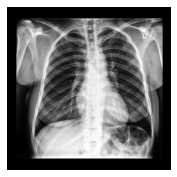

In [12]:
dl = learn.dls.test_dl(test_imgs)
dl.show_batch()

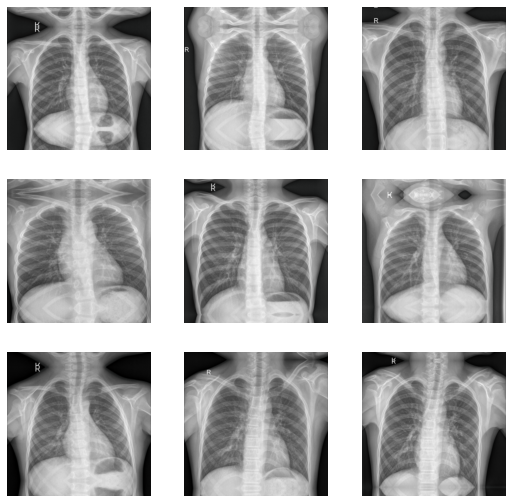

In [15]:
dl = learn.dls.test_dl(test_imgs)
dl.show_batch()

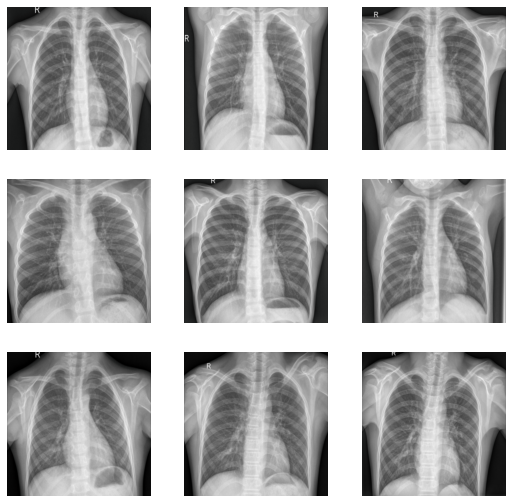

In [10]:
dl = learn.dls.test_dl(test_imgs)
dl.show_batch()

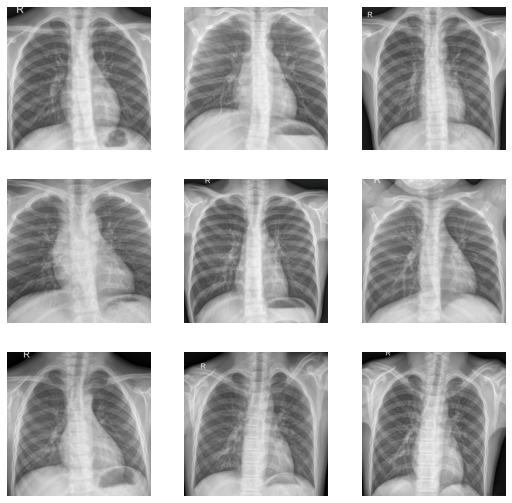

In [23]:
dl = learn.dls.test_dl(test_imgs)
dl.show_batch()

In [13]:
preds = learn.get_preds(dl=dl)

KeyboardInterrupt: 

(448, 448)


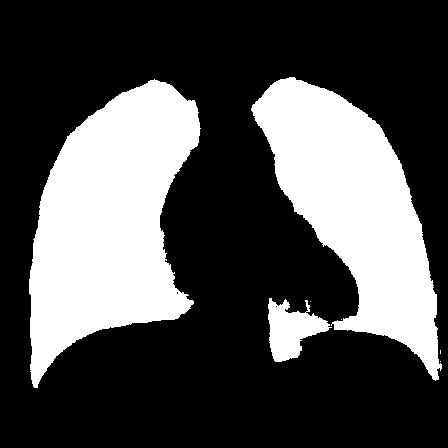

In [24]:
pred_1 = preds[0][3]
pred_arx = pred_1.argmax(dim=0)
pred_arx = pred_arx.numpy()
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)
im = Image.fromarray(rescaled)
print(im.size)
im
# plt.imshow(pred_arx)

In [ ]:
mask_path = img_path/"masks_raw"
mask_path.mkdir()

In [26]:
for i, path in tqdm(enumerate(test_imgs)):
    pred = preds[0][i]
    pred_arg = pred.argmax(dim=0).numpy()
    rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save(mask_path/path.name)

62it [00:02, 27.34it/s]


# Free Memory

In [2]:
import gc
import torch
learn, lungs, dls = None, None, None
gc.collect()
torch.cuda.empty_cache()

In [3]:
!nvidia-smi

Sun Dec 12 21:17:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    39W / 300W |  16154MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------